<a href="https://colab.research.google.com/github/mannam95/Deep_Learning_Programming/blob/main/Assignment3/Assignment_3_CNN_Srinath.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team Assignment


1.   Srinath Mannam (229750)
2.   Meghana Rao (234907)
3.   Govind Shukla (235192)

# import statements

In [61]:
import os
import tensorflow as tf
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda

# Change the directory

In [2]:
working_directory = '/content/drive/My Drive/Colab Notebooks/OVGU/Deep_Learning/Second_Assignment'
def colabDrive():
    from google.colab import drive
    drive.mount("/content/drive")

    if os.getcwd() !=  working_directory:
      os.chdir(working_directory)
    print(os.getcwd())

In [3]:
#colabDrive()

# Clears GPU memory

In [4]:
def clearGPUMemory():
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()
    !nvidia-smi

In [5]:
#clearGPUMemory()

# Prepare the data

## Normal MNIST

11501568/11490434 [==============================] - 0s 0us/step


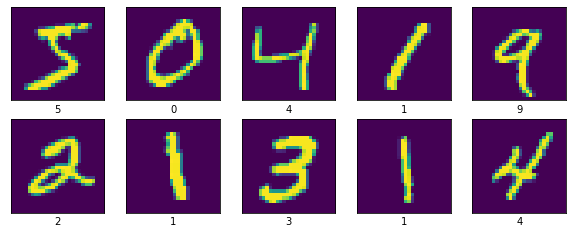

In [40]:
# just data stuff
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(train_labels[i])
plt.show()

train_data = tf.data.Dataset.from_tensor_slices(
    (train_images.reshape([-1, 28, 28, 1]).astype(np.float32) / 255, train_labels.astype(np.int32)))
train_data = train_data.shuffle(buffer_size=60000).batch(128)

# note: we batch the test data, but do not shuffle/repeat
test_data = tf.data.Dataset.from_tensor_slices(
    (test_images.reshape([-1, 28, 28, 1]).astype(np.float32) / 255, test_labels.astype(np.int32))).batch(128)

## Fasion MNIST

4431872/4422102 [==============================] - 0s 0us/step


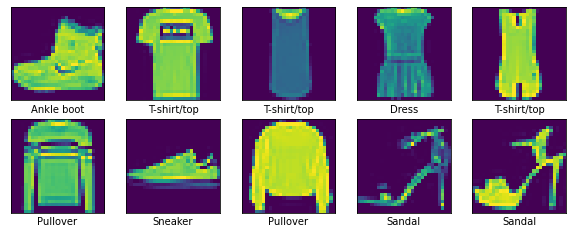

In [41]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_fasion_images, train_fasion_labels), (test_fasion_images, test_fasion_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_fasion_images[i])
    plt.xlabel(class_names[train_fasion_labels[i]])
plt.show()


train_fasion_data = tf.data.Dataset.from_tensor_slices(
    (train_fasion_images.reshape([-1, 28, 28, 1]).astype(np.float32) / 255, train_fasion_labels.astype(np.int32)))
train_fasion_data = train_fasion_data.shuffle(buffer_size=60000).batch(128)

# note: we batch the test data, but do not shuffle/repeat
test_fasion_data = tf.data.Dataset.from_tensor_slices(
    (test_fasion_images.reshape([-1, 28, 28, 1]).astype(np.float32) / 255, test_fasion_labels.astype(np.int32))).batch(128)

## CIFAR Dataset

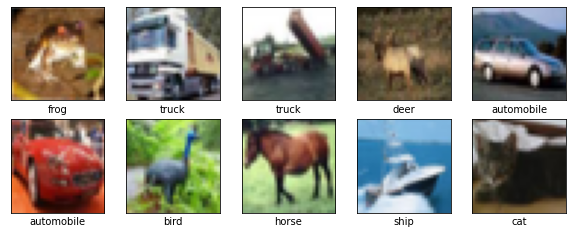

In [83]:
cifar10 = tf.keras.datasets.cifar10

(train_cifar_images, train_cifar_labels), (test_cifar_images, test_cifar_labels) = cifar10.load_data()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# The CIFAR labels happen to be arrays
# So reshape them
train_cifar_labels = train_cifar_labels.reshape((-1,))
test_cifar_labels = test_cifar_labels.reshape((-1,))

train_cifar_images = train_cifar_images.astype(np.float32) / 255
train_cifar_labels = train_cifar_labels.astype(np.int32)

datagen = ImageDataGenerator(
              rotation_range=15,
              horizontal_flip=True,
              width_shift_range=0.1,
              height_shift_range=0.1
            )
datagen.fit(train_cifar_images)

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_cifar_images[i])
    plt.xlabel(class_names[train_cifar_labels[i]])
plt.show()


train_cifar_data = tf.data.Dataset.from_tensor_slices((train_cifar_images, train_cifar_labels))
train_cifar_data = train_cifar_data.shuffle(buffer_size=60000).batch(128)

# note: we batch the test data, but do not shuffle/repeat
test_cifar_data = tf.data.Dataset.from_tensor_slices(
    (test_cifar_images.astype(np.float32) / 255, test_cifar_labels.astype(np.int32))).batch(128)

# Models Define

## Normal MNIST

for normal MNIST the model gets very high accuracy even with small network size and less training steps

In [45]:
def model_normal_MNIST():
  #model params declarations Start

  train_steps = 2500
  EPOCHS = 5
  input_shape = (28, 28, 1)
  num_classes = 10

  model = tf.keras.Sequential(
      [ tf.keras.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes)
      ],
      name="Normal_MNIST",
  )

  model.summary()

  optimizer = tf.optimizers.SGD(0.5)  # tune this
  # from_logits = True!! #neverforget
  loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
  #model params declarations End


  #Training Progress Start
  print("Traing Start")
  train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

  for epoch in range(EPOCHS):
    print("Epoch : ", epoch+1)
    for step, (image_batch, label_batch) in enumerate(train_data):

        with tf.GradientTape() as tape:
            logits = model(image_batch)
            # loss format is generally: first argument targets, second argument outputs
            loss = loss_fn(label_batch, logits)

        # if you didn't build the model, it is important that you get the variables
        # AFTER the model has been called the first time
        variables = model.trainable_variables
        gradients = tape.gradient(loss, variables)
          
        optimizer.apply_gradients(zip(gradients, variables))
        
        train_acc_metric(label_batch, logits)
        
        if not step % 100:
            # this is different from before. there, we only evaluated accuracy
            # for one batch. Now, we always average over 100 batches
            print("Loss: {} Accuracy: {}".format(loss, train_acc_metric.result()))
            train_acc_metric.reset_states()
  print("Traing End")
  #Training Progress End


  #Testing

  # this is very convenient -- before, we usually had code that
  # evaluates the whole test set at once -- this won't work for
  # large datasets/models. With metrics, we can just iterate
  # over the data and the metric takes care of averaging etc.

  test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  for image_batch, label_batch in test_data:
      test_acc_metric(label_batch, model(image_batch))
  print("Test acc: {}".format(test_acc_metric.result()))

  #Testing



In [46]:
model_normal_MNIST();

Model: "Normal_MNIST"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_83 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 1600)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)               

## Fashion MNIST

### Fashion MNIST1

The network size is same as used for normal MNIST and the test accuracy is only 88%

In [48]:
def model_fashion_MNIST1():
  #model params declarations Start

  train_steps = 2500
  EPOCHS = 5
  input_shape = (28, 28, 1)
  num_classes = 10

  model = tf.keras.Sequential(
      [ tf.keras.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes)
      ],
      name="Fashion_MNIST1",
  )

  model.summary()

  optimizer = tf.optimizers.SGD(0.5)  # tune this
  # from_logits = True!! #neverforget
  loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
  #model params declarations End


  #Training Progress Start
  print("Traing Start")
  train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

  for epoch in range(EPOCHS):
    print("Epoch : ", epoch+1)
    for step, (image_batch, label_batch) in enumerate(train_fasion_data):

        with tf.GradientTape() as tape:
            logits = model(image_batch)
            # loss format is generally: first argument targets, second argument outputs
            loss = loss_fn(label_batch, logits)

        # if you didn't build the model, it is important that you get the variables
        # AFTER the model has been called the first time
        variables = model.trainable_variables
        gradients = tape.gradient(loss, variables)
          
        optimizer.apply_gradients(zip(gradients, variables))
        
        train_acc_metric(label_batch, logits)
        
        if not step % 100:
            # this is different from before. there, we only evaluated accuracy
            # for one batch. Now, we always average over 100 batches
            print("Loss: {} Accuracy: {}".format(loss, train_acc_metric.result()))
            train_acc_metric.reset_states()
  print("Traing End")
  #Training Progress End


  #Testing

  # this is very convenient -- before, we usually had code that
  # evaluates the whole test set at once -- this won't work for
  # large datasets/models. With metrics, we can just iterate
  # over the data and the metric takes care of averaging etc.

  test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  for image_batch, label_batch in test_fasion_data:
      test_acc_metric(label_batch, model(image_batch))
  print("Test acc: {}".format(test_acc_metric.result()))

  #Testing



In [49]:
model_fashion_MNIST1();

Model: "Fashion_MNIST1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 1600)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)             

### Fashion MNIST2



1.   Increased the network size and also increased kernel size upto 256
2.   Added Batch Normalization in between some layers
3.   Changed the optimizer to Adam
4.   The test accuracy ended up with 92%
5.   The params size is apprx 1.15M



In [51]:
def model_fashion_MNIST2():
  #model params declarations Start

  train_steps = 2500
  EPOCHS = 5
  input_shape = (28, 28, 1)
  num_classes = 10

  model = tf.keras.Sequential(
      [ tf.keras.Input(shape=input_shape),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes)
      ],
      name="Fashion_MNIST2",
  )

  model.summary()

  optimizer = tf.optimizers.Adam(learning_rate=1e-3)  # tune this
  # from_logits = True!! #neverforget
  loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
  #model params declarations End


  #Training Progress Start
  print("Training Start")
  train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

  for epoch in range(EPOCHS):
    print("Epoch : ", epoch+1)
    for step, (image_batch, label_batch) in enumerate(train_fasion_data):

        with tf.GradientTape() as tape:
            logits = model(image_batch)
            # loss format is generally: first argument targets, second argument outputs
            loss = loss_fn(label_batch, logits)

        # if you didn't build the model, it is important that you get the variables
        # AFTER the model has been called the first time
        variables = model.trainable_variables
        gradients = tape.gradient(loss, variables)
          
        optimizer.apply_gradients(zip(gradients, variables))
        
        train_acc_metric(label_batch, logits)
        
        if not step % 100:
            # this is different from before. there, we only evaluated accuracy
            # for one batch. Now, we always average over 100 batches
            print("Loss: {} Accuracy: {}".format(loss, train_acc_metric.result()))
            train_acc_metric.reset_states()
  print("Training End")
  #Training Progress End


  #Testing

  # this is very convenient -- before, we usually had code that
  # evaluates the whole test set at once -- this won't work for
  # large datasets/models. With metrics, we can just iterate
  # over the data and the metric takes care of averaging etc.

  test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  for image_batch, label_batch in test_fasion_data:
      test_acc_metric(label_batch, model(image_batch))
  print("Test acc: {}".format(test_acc_metric.result()))

  #Testing



In [52]:
model_fashion_MNIST2();

Model: "Fashion_MNIST2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_87 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_81 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_82 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
batch_normalization_83 (Batc (None, 13, 13, 128)    

### Fashion MNIST3



1.   The network size increased and the params size is apprx 13M
2.   But the accuracy increase is just 1% compared to the previous model



In [53]:
def model_fashion_MNIST3():
  #model params declarations Start

  train_steps = 2500
  EPOCHS = 5
  input_shape = (28, 28, 1)
  num_classes = 10

  model = tf.keras.Sequential(
      [ tf.keras.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
       
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),
       
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes)
      ],
      name="Fashion_MNIST3",
  )

  model.summary()

  optimizer = tf.optimizers.Adam(learning_rate=1e-3)  # tune this
  # from_logits = True!! #neverforget
  loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
  #model params declarations End


  #Training Progress Start
  print("Training Start")
  train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

  for epoch in range(EPOCHS):
    print("Epoch : ", epoch+1)
    for step, (image_batch, label_batch) in enumerate(train_fasion_data):

        with tf.GradientTape() as tape:
            logits = model(image_batch)
            # loss format is generally: first argument targets, second argument outputs
            loss = loss_fn(label_batch, logits)

        # if you didn't build the model, it is important that you get the variables
        # AFTER the model has been called the first time
        variables = model.trainable_variables
        gradients = tape.gradient(loss, variables)
          
        optimizer.apply_gradients(zip(gradients, variables))
        
        train_acc_metric(label_batch, logits)
        
        if not step % 100:
            # this is different from before. there, we only evaluated accuracy
            # for one batch. Now, we always average over 100 batches
            print("Loss: {} Accuracy: {}".format(loss, train_acc_metric.result()))
            train_acc_metric.reset_states()
  print("Training End")
  #Training Progress End


  #Testing

  # this is very convenient -- before, we usually had code that
  # evaluates the whole test set at once -- this won't work for
  # large datasets/models. With metrics, we can just iterate
  # over the data and the metric takes care of averaging etc.

  test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  for image_batch, label_batch in test_fasion_data:
      test_acc_metric(label_batch, model(image_batch))
  print("Test acc: {}".format(test_acc_metric.result()))

  #Testing



In [54]:
model_fashion_MNIST3();

Model: "Fashion_MNIST3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_93 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_87 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_88 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
dropout_46 (Dropout)         (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 14, 14, 64)     

# CIFAR Dataset

### CIFAR 1



1.   The network is exactly similar to the previous model.
2.   The test accuracy is 72%



In [55]:
def model_cifar1():
  #model params declarations Start

  train_steps = 2500
  EPOCHS = 5
  input_shape = (32, 32, 3)
  num_classes = 10

  model = tf.keras.Sequential(
      [ tf.keras.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
       
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),
       
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes)
      ],
      name="CIFAR1",
  )

  model.summary()

  optimizer = tf.optimizers.Adam(learning_rate=1e-3)   # tune this
  # from_logits = True!! #neverforget
  loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
  #model params declarations End


  #Training Progress Start
  print("Traing Start")
  train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

  for epoch in range(EPOCHS):
    print("Epoch : ", epoch+1)
    for step, (image_batch, label_batch) in enumerate(train_cifar_data):

        with tf.GradientTape() as tape:
            logits = model(image_batch)
            # loss format is generally: first argument targets, second argument outputs
            loss = loss_fn(label_batch, logits)

        # if you didn't build the model, it is important that you get the variables
        # AFTER the model has been called the first time
        variables = model.trainable_variables
        gradients = tape.gradient(loss, variables)
          
        optimizer.apply_gradients(zip(gradients, variables))
        
        train_acc_metric(label_batch, logits)
        
        if not step % 100:
            # this is different from before. there, we only evaluated accuracy
            # for one batch. Now, we always average over 100 batches
            print("Loss: {} Accuracy: {}".format(loss, train_acc_metric.result()))
            train_acc_metric.reset_states()
  print("Traing End")
  #Training Progress End


  #Testing

  # this is very convenient -- before, we usually had code that
  # evaluates the whole test set at once -- this won't work for
  # large datasets/models. With metrics, we can just iterate
  # over the data and the metric takes care of averaging etc.

  test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  for image_batch, label_batch in test_cifar_data:
      test_acc_metric(label_batch, model(image_batch))
  print("Test acc: {}".format(test_acc_metric.result()))

  #Testing



In [56]:
model_cifar1();

Model: "CIFAR1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_97 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_92 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_93 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_51 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 16, 16, 64)        0    

### CIFAR 2



1.   The network size is reduced to make the model simple
2.   But still the test accuracy is same 72%



In [57]:
def model_cifar2():
  #model params declarations Start

  train_steps = 2500
  EPOCHS = 5
  input_shape = (32, 32, 3)
  num_classes = 10

  model = tf.keras.Sequential(
      [ tf.keras.Input(shape=input_shape),
        tf.keras.layers.Conv2D(96, kernel_size=(3, 3), activation="relu"),
       
        tf.keras.layers.Conv2D(96, kernel_size=(3, 3), activation="relu", strides=2),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(192, kernel_size=(3, 3), activation="relu"),
       
        tf.keras.layers.Conv2D(192, kernel_size=(3, 3), activation="relu", strides=2),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(num_classes)
      ],
      name="CIFAR2",
  )

  model.summary()

  optimizer = tf.optimizers.Adam(learning_rate=1e-3)  # tune this
  # from_logits = True!! #neverforget
  loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
  #model params declarations End


  #Training Progress Start
  print("Traing Start")
  train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

  for epoch in range(EPOCHS):
    print("Epoch : ", epoch+1)
    for step, (image_batch, label_batch) in enumerate(train_cifar_data):

        with tf.GradientTape() as tape:
            logits = model(image_batch)
            # loss format is generally: first argument targets, second argument outputs
            loss = loss_fn(label_batch, logits)

        # if you didn't build the model, it is important that you get the variables
        # AFTER the model has been called the first time
        variables = model.trainable_variables
        gradients = tape.gradient(loss, variables)
          
        optimizer.apply_gradients(zip(gradients, variables))
        
        train_acc_metric(label_batch, logits)
        
        if not step % 100:
            # this is different from before. there, we only evaluated accuracy
            # for one batch. Now, we always average over 100 batches
            print("Loss: {} Accuracy: {}".format(loss, train_acc_metric.result()))
            train_acc_metric.reset_states()
  print("Traing End")
  #Training Progress End


  #Testing

  # this is very convenient -- before, we usually had code that
  # evaluates the whole test set at once -- this won't work for
  # large datasets/models. With metrics, we can just iterate
  # over the data and the metric takes care of averaging etc.

  test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  for image_batch, label_batch in test_cifar_data:
      test_acc_metric(label_batch, model(image_batch))
  print("Test acc: {}".format(test_acc_metric.result()))

  #Testing



In [58]:
model_cifar2();

Model: "CIFAR2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_101 (Conv2D)          (None, 30, 30, 96)        2688      
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 14, 14, 96)        83040     
_________________________________________________________________
dropout_56 (Dropout)         (None, 14, 14, 96)        0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 12, 12, 192)       166080    
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 5, 5, 192)         331968    
_________________________________________________________________
dropout_57 (Dropout)         (None, 5, 5, 192)         0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 4800)              0    

### CIFAR 3



1.   Similar to the prveious model
2.   Increased the training steps from 2500 to 15640
3.   The accuracy has improved just 1% compared to previous model which is 73%



In [115]:
def model_cifar3():
  #model params declarations Start

  train_steps = 15640
  EPOCHS = 40
  input_shape = (32, 32, 3)
  num_classes = 10

  model = tf.keras.Sequential(
      [ tf.keras.Input(shape=(32, 32, 3)),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.2),
      
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.3),
      
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10)
      ],
      name="CIFAR3",
  )

  model.summary()

  optimizer = tf.optimizers.Adam(learning_rate=1e-3, decay=1e-6)  # tune this
  # from_logits = True!! #neverforget
  loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
  #model params declarations End


  #Training Progress Start
  print("Traing Start")
  train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

  for epoch in range(EPOCHS):
    print("Epoch : ", epoch+1)
    for step, (image_batch, label_batch) in enumerate(train_cifar_data):

        with tf.GradientTape() as tape:
            logits = model(image_batch)
            # loss format is generally: first argument targets, second argument outputs
            loss = loss_fn(label_batch, logits)

        # if you didn't build the model, it is important that you get the variables
        # AFTER the model has been called the first time
        variables = model.trainable_variables
        gradients = tape.gradient(loss, variables)
          
        optimizer.apply_gradients(zip(gradients, variables))
        
        train_acc_metric(label_batch, logits)
        
        if not step % 100:
            # this is different from before. there, we only evaluated accuracy
            # for one batch. Now, we always average over 100 batches
            print("Loss: {} Accuracy: {}".format(loss, train_acc_metric.result()))
            train_acc_metric.reset_states()
  print("Traing End")
  #Training Progress End


  #Testing

  # this is very convenient -- before, we usually had code that
  # evaluates the whole test set at once -- this won't work for
  # large datasets/models. With metrics, we can just iterate
  # over the data and the metric takes care of averaging etc.

  test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  for image_batch, label_batch in test_cifar_data:
      test_acc_metric(label_batch, model(image_batch))
  print("Final Test acc: {}".format(test_acc_metric.result()))

  #Testing



In [116]:
model_cifar3();

Model: "CIFAR3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_168 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_163 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_124 (Dropout)        (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_169 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_164 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 8, 8, 64)          0    

### CIFAR 4 Data Augmentation



1.   After trying different configuration understood that changing configurations might not be helpful anymore (This is my assumption).
2.   So added data augmentation to the data.
3.   The network size is similar to the old one and the training steps are 50000.
4.   The test accuracy is 82%.



In [102]:
def model_cifar4():
  #model params declarations Start

  train_steps = 50000
  EPOCHS = 1
  input_shape = (32, 32, 3)
  num_classes = 10

  model = tf.keras.Sequential(
      [ tf.keras.Input(shape=(32, 32, 3)),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.2),
      
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.3),
      
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10)
      ],
      name="CIFAR4",
  )

  model.summary()

  optimizer = tf.optimizers.Adam(learning_rate=1e-3, decay=1e-6)  # tune this
  # from_logits = True!! #neverforget
  loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
  #model params declarations End


  #Training Progress Start
  print("Traing Start")
  train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

  train_cifar_dataAug = datagen.flow(train_cifar_images, train_cifar_labels, batch_size=128)

  for step, (image_batch, label_batch) in enumerate(train_cifar_dataAug):
      
      if step > train_steps:
          break

      with tf.GradientTape() as tape:
          logits = model(image_batch)
          # loss format is generally: first argument targets, second argument outputs
          loss = loss_fn(label_batch, logits)

      # if you didn't build the model, it is important that you get the variables
      # AFTER the model has been called the first time
      variables = model.trainable_variables
      gradients = tape.gradient(loss, variables)
        
      optimizer.apply_gradients(zip(gradients, variables))
      
      train_acc_metric(label_batch, logits)
      
      if not step % 500:
          # this is different from before. there, we only evaluated accuracy
          # for one batch. Now, we always average over 100 batches
          print("Loss: {} Accuracy: {}".format(loss, train_acc_metric.result()))
          train_acc_metric.reset_states()
  print("Traing End")
  #Training Progress End


  #Testing

  # this is very convenient -- before, we usually had code that
  # evaluates the whole test set at once -- this won't work for
  # large datasets/models. With metrics, we can just iterate
  # over the data and the metric takes care of averaging etc.

  test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  for image_batch, label_batch in test_cifar_data:
      test_acc_metric(label_batch, model(image_batch))
  print("Final Test acc: {}".format(test_acc_metric.result()))

  #Testing



In [103]:
model_cifar4();

Model: "CIFAR4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_147 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_140 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_95 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_100 (Dropout)        (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_148 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_141 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 8, 8, 64)          0    

### CIFAR 5 Data Augmentation



1.   The network size is increased and the params are apprx 16M and also the data is augmented.
2.   The training steps are changed to 15000.
3.   The accuracy achieved was 83%.



In [113]:
def model_cifar5():
  #model params declarations Start

  train_steps = 15000
  EPOCHS = 1
  input_shape = (32, 32, 3)
  num_classes = 10

  model = tf.keras.Sequential(
      [ tf.keras.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
       
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),
       
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes)
      ],
      name="CIFAR5",
  )

  model.summary()

  optimizer = tf.optimizers.Adam(learning_rate=1e-3, decay=1e-6)  # tune this
  # from_logits = True!! #neverforget
  loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
  #model params declarations End


  #Training Progress Start
  print("Training Start")
  train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

  train_cifar_dataAug = datagen.flow(train_cifar_images, train_cifar_labels, batch_size=128)

  for step, (image_batch, label_batch) in enumerate(train_cifar_dataAug):
      
      if step > train_steps:
          break

      with tf.GradientTape() as tape:
          logits = model(image_batch)
          # loss format is generally: first argument targets, second argument outputs
          loss = loss_fn(label_batch, logits)

      # if you didn't build the model, it is important that you get the variables
      # AFTER the model has been called the first time
      variables = model.trainable_variables
      gradients = tape.gradient(loss, variables)
        
      optimizer.apply_gradients(zip(gradients, variables))
      
      train_acc_metric(label_batch, logits)
      
      if not step % 500:
          # this is different from before. there, we only evaluated accuracy
          # for one batch. Now, we always average over 100 batches
          print("Step No: {} Loss: {} Accuracy: {}".format(step, loss, train_acc_metric.result()))
          train_acc_metric.reset_states()
  print("Training End")
  #Training Progress End


  #Testing

  # this is very convenient -- before, we usually had code that
  # evaluates the whole test set at once -- this won't work for
  # large datasets/models. With metrics, we can just iterate
  # over the data and the metric takes care of averaging etc.

  test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  for image_batch, label_batch in test_cifar_data:
      test_acc_metric(label_batch, model(image_batch))
  print("Final Test acc: {}".format(test_acc_metric.result()))

  #Testing



In [114]:
model_cifar5();

Model: "CIFAR5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_164 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_158 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_165 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_159 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_119 (Dropout)        (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_166 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_103 (MaxPoolin (None, 16, 16, 64)        0    

#References


1.   https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch
2.   https://ovgu-ailab.github.io/idl2021/assignments/3/mlp_keras.ipynb
3.   https://keras.io/examples/vision/mnist_convnet/
4.   https://medium.com/@mjbhobe/classifying-fashion-with-a-keras-cnn-achieving-94-accuracy-part-1-1ffcb7e5f61a
5.   https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/
6.   https://github.com/moritzhambach/Image-Augmentation-in-Keras-CIFAR-10-/blob/master/CNN%20with%20Image%20Augmentation%20(CIFAR10).ipynb

